In [1]:
# from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage
# from langchain.messages import ToolMessage
from typing import Literal, List

from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage
from langchain_core.retrievers import BaseRetriever

c:\Users\jw160\project\RAG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [3]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [4]:
# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], operator.add]
#     llm_calls: int

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int
    intent: str  # 의도 분류 결과를 저장하기 위해 추가
    retrieved_docs: List[Document]  # 선택사항: 검색된 문서 저장

In [5]:
model = init_chat_model(
    "smollm2",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50,
    model_kwargs={
    "num_predict": 50  # Ollama 전용 파라미터
    }
)


In [6]:
def intent_classifier(state: dict):
    """사용자 메시지에서 의도를 분류"""
    # dict 또는 Message 객체 모두 처리
    last_message = state["messages"][-1] if state["messages"] else None
    if last_message:
        if isinstance(last_message, dict):
            user_message = last_message.get("content", "")
        else:
            user_message = last_message.content
    else:
        user_message = ""
    
    response = model.invoke(
        [
            SystemMessage(
                content="""당신은 의도 분류 전문가입니다. 주어진 문장의 의도를 다음 중 하나로 분류하세요:
- 정보요청: 특정 주제에 대한 정보나 설명을 요청
- 개념정의: 용어나 개념의 정의를 요청
- 비교분석: 두 가지 이상의 개념을 비교하거나 관계를 파악
- 기술질문: 작동 방식이나 방법론에 대한 질문
- 기타: 위에 해당하지 않는 경우

의도만 답변하세요. 예: "정보요청" """
            ),
            HumanMessage(content=f"문장: {user_message}")
        ]
    )
    
    return {
        "messages": state["messages"] + [response],
        "intent": response.content.strip(),
        "llm_calls": state.get('llm_calls', 0) + 1
    }

def retriever_call(state: dict):
    """의도에 따라 적절한 검색 수행"""
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 2}
    )
    
    # 사용자 메시지에서 검색어 추출 (dict 또는 Message 객체 처리)
    first_message = state["messages"][0] if state["messages"] else None
    if first_message:
        if isinstance(first_message, dict):
            user_message = first_message.get("content", "")
        else:
            user_message = first_message.content
    else:
        user_message = ""
    
    docs = retriever.invoke(user_message)
    
    return {
        "messages": state["messages"] + [
            SystemMessage(content=f"참고 문서:\n{chr(10).join([d.page_content for d in docs])}")
        ],
        "retrieved_docs": docs
    }

def llm_call(state: dict):
    """의도에 맞는 응답 생성"""
    # 사용자 메시지 추출 (dict 또는 Message 객체 처리)
    first_message = state["messages"][0] if state["messages"] else None
    if first_message:
        if isinstance(first_message, dict):
            user_message = first_message.get("content", "")
        else:
            user_message = first_message.content
    else:
        user_message = ""
    
    intent = state.get("intent", "정보요청")
    
    intent_prompts = {
        "정보요청": "사용자가 요청한 정보를 참고 문서를 바탕으로 자세히 설명해주세요.",
        "개념정의": "참고 문서를 바탕으로 요청한 개념의 정의를 명확하게 설명해주세요.",
        "비교분석": "참고 문서를 바탕으로 요청한 개념들의 차이점과 관계를 비교하여 설명해주세요.",
        "기술질문": "참고 문서를 바탕으로 작동 방식이나 방법론을 설명해주세요.",
        "기타": "참고 문서를 바탕으로 사용자의 질문에 답변해주세요."
    }
    
    response = model.invoke(
        state["messages"] + [
            SystemMessage(content=intent_prompts.get(intent, intent_prompts["기타"]))
        ]
    )
    
    return {
        "messages": state["messages"] + [response],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [7]:
#  content="당신은 감정 분석 전문가입니다. 문장의 감정을 분석하여 반드시 '긍정' 또는 '부정' 중 하나만 답변하세요. 추가 설명 없이 감정만 판단하세요"
# content="당신은 키워드 추출 전문가입니다. 주어진 문장에서 핵심 키워드만 뽑아 한글 쉼표(,)로 구분하여 나열하세요. 불필요한 설명 없이 키워드만 답변하세요."

In [8]:
graph = StateGraph(MessagesState)
graph.add_node("intent_classifier", intent_classifier)
graph.add_node("retriever_call", retriever_call)
graph.add_node("llm_call", llm_call)

graph.add_edge(START, "intent_classifier")
graph.add_edge("intent_classifier", "retriever_call")
graph.add_edge("retriever_call", "llm_call")
graph.add_edge("llm_call", END)

graph = graph.compile()

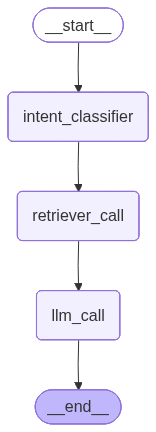

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [10]:
graph.invoke({"messages": [{"role": "user", "content": "오늘 날씨가 좋아요."}]})

{'messages': [{'role': 'user', 'content': '오늘 날씨가 좋아요.'},
  {'role': 'user', 'content': '오늘 날씨가 좋아요.'},
  AIMessage(content='정보요청', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:39:06.522839067Z', 'done': True, 'done_reason': 'stop', 'total_duration': 16422723780, 'load_duration': 45502114, 'prompt_eval_count': 447, 'prompt_eval_duration': 12757727391, 'eval_count': 13, 'eval_duration': 3606491001, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--03690be4-c0c5-4184-af35-b59961e8f487-0', usage_metadata={'input_tokens': 447, 'output_tokens': 13, 'total_tokens': 460}),
  {'role': 'user', 'content': '오늘 날씨가 좋아요.'},
  {'role': 'user', 'content': '오늘 날씨가 좋아요.'},
  AIMessage(content='정보요청', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:39:06.522839067Z', 'done': True, 'done_reason': 'stop', 'total_duration': 16422723780, 'load_duration': 45502114, 'prompt_eval_count': 447

In [11]:
graph.invoke({"messages": [{"role": "user", "content": "컴퓨터 비전에 대해 알려줘"}]})

{'messages': [{'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  {'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  AIMessage(content='개념정의: 컴퓨터 비전', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:40:13.142067768Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13778134777, 'load_duration': 42795403, 'prompt_eval_count': 454, 'prompt_eval_duration': 9344027202, 'eval_count': 28, 'eval_duration': 4367680781, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--cb90c8ac-168c-496a-b756-3195b9a2a57b-0', usage_metadata={'input_tokens': 454, 'output_tokens': 28, 'total_tokens': 482}),
  {'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  {'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  AIMessage(content='개념정의: 컴퓨터 비전', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T12:40:13.142067768Z', 'done': True, 'done_reason': 'stop', 'total_duration': 13778134777, 'load_duration': 4279540

In [12]:
# 키워드 추출, 감정 분석, 코딩 등 활용 고려

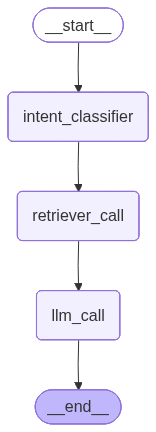

In [13]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))